In [ ]:
import shap
import lime
import torch
import numpy as np
import pandas as pd
import networkx as nx
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from lime import lime_tabular
from torch_geometric.data import Data
from sklearn.model_selection import KFold
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.explain import GNNExplainer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.loader import DataLoader as GeometricDataLoader
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

In [29]:
# Define Advanced GNN Model
class AdvancedGNNModel(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, dropout):
        super(AdvancedGNNModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GATConv(64, 128, heads = 4, concat = True)
        self.conv3 = GCNConv(128 * 4, 64)  # GAT outputs heads*hidden channels
        self.fc1 = torch.nn.Linear(64, 32)
        self.fc2 = torch.nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(p = dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
def visualize_graph(edge_index, num_nodes = 12):
    """
    Visualize a subgraph consisting of 'num_nodes' nodes and their corresponding edges.
    """
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    for i, j in edge_index.t().tolist():
        if i < num_nodes and j < num_nodes:
            G.add_edge(i, j)
    plt.figure(figsize=(12, 8))
    nx.draw(G, with_labels = True, node_color = 'skyblue', node_size = 700, edge_color = 'k')
    plt.title(f'Subgraph with {num_nodes} Nodes')
    plt.show()

def create_custom_edge_index():
    """
    Create custom edge index based on edge list.
    """
    custom_edges = [
        (0, 10), (1, 10), (2, 5), (2, 7), (2, 10), (2, 11),
        (3, 10), (4, 10), (5, 8), (6, 10), (7, 8), (8, 9), (8, 11)
    ]
    edges = []
    for edge in custom_edges:
        i, j = edge
        edges.append([i, j])
        edges.append([j, i])  # Undirected graph
    return torch.tensor(edges, dtype=torch.long).t().contiguous()

# Create Data objects for training and testing sets
def create_graph_data(features, labels):
    edge_index = create_custom_edge_index()  # Custom edge index for all graphs
    data = Data(x = features, edge_index = edge_index, y = labels)
    return data

In [30]:
# Load and preprocess the data
InputData = pd.read_csv('Dataset_spine_clean.csv')
node_features = torch.tensor(InputData.iloc[:, 1:13].values, dtype=torch.float)
labels_string = InputData.iloc[:, 13].values
labels = torch.tensor([1 if label == 'Normal' else 0 for label in labels_string], dtype=torch.long)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(node_features, labels, test_size=0.2, random_state=42)

train_data = create_graph_data(X_train, y_train)
test_data = create_graph_data(X_test, y_test)

# Create DataLoader instances
train_loader = GeometricDataLoader([train_data], batch_size=1, shuffle=True)
test_loader = GeometricDataLoader([test_data], batch_size=1, shuffle=False)

In [31]:
# Initialize the model, loss function, and optimizer
model = AdvancedGNNModel(num_node_features = 12, num_classes = 2, dropout = 0.1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002, weight_decay = 1e-6)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.9)  # Learning rate scheduler

# Train the model
epochs = 1000
loss_values = []
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
        optimizer.step()
    ##scheduler.step()  # Update learning rate
        loss_values.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/1000], Loss: 1.1332
Epoch [2/1000], Loss: 1.6880
Epoch [3/1000], Loss: 1.0801
Epoch [4/1000], Loss: 0.5890
Epoch [5/1000], Loss: 0.7119
Epoch [6/1000], Loss: 0.6588
Epoch [7/1000], Loss: 0.5572
Epoch [8/1000], Loss: 0.5787
Epoch [9/1000], Loss: 0.5451
Epoch [10/1000], Loss: 0.5311
Epoch [11/1000], Loss: 0.5170
Epoch [12/1000], Loss: 0.4921
Epoch [13/1000], Loss: 0.4858
Epoch [14/1000], Loss: 0.4668
Epoch [15/1000], Loss: 0.4838
Epoch [16/1000], Loss: 0.4479
Epoch [17/1000], Loss: 0.4653
Epoch [18/1000], Loss: 0.4807
Epoch [19/1000], Loss: 0.4458
Epoch [20/1000], Loss: 0.4537
Epoch [21/1000], Loss: 0.4500
Epoch [22/1000], Loss: 0.4606
Epoch [23/1000], Loss: 0.4438
Epoch [24/1000], Loss: 0.4322
Epoch [25/1000], Loss: 0.4366
Epoch [26/1000], Loss: 0.4412
Epoch [27/1000], Loss: 0.4447
Epoch [28/1000], Loss: 0.4140
Epoch [29/1000], Loss: 0.4526
Epoch [30/1000], Loss: 0.4249
Epoch [31/1000], Loss: 0.4175
Epoch [32/1000], Loss: 0.4153
Epoch [33/1000], Loss: 0.4190
Epoch [34/1000], Lo

In [32]:
# Evaluate the model
model.eval()
true_labels = []
predictions = []
probs = []

with torch.no_grad():
    for batch in test_loader:
        out = model(batch)
        _, pred = out.max(dim=1)
        predictions.extend(pred.tolist())
        true_labels.extend(batch.y.tolist())
        probs.extend(F.softmax(out, dim = 1)[:, 1].tolist())

# Convert lists to numpy arrays for metric calculation
true_labels = np.array(true_labels)
predictions = np.array(predictions)
probs = np.array(probs)

# Calculate metrics
test_accuracy = accuracy_score(true_labels, predictions)
test_precision = precision_score(true_labels, predictions, average='macro', zero_division=0)
test_recall = recall_score(true_labels, predictions, average='macro', zero_division=0)
test_f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

Test Accuracy: 0.8387
Test Precision: 0.8199
Test Recall: 0.7715
Test F1 Score: 0.7894


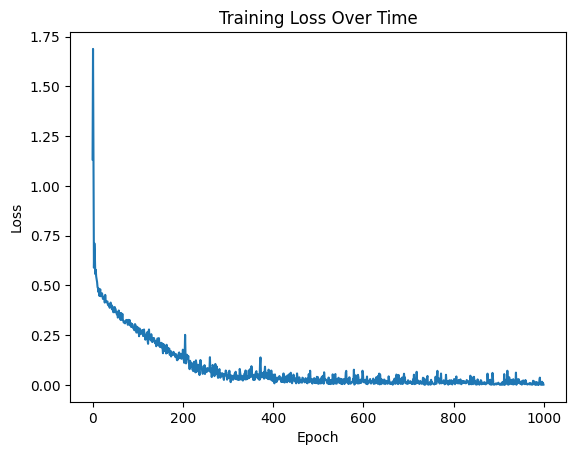

In [33]:
# Plot the loss
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

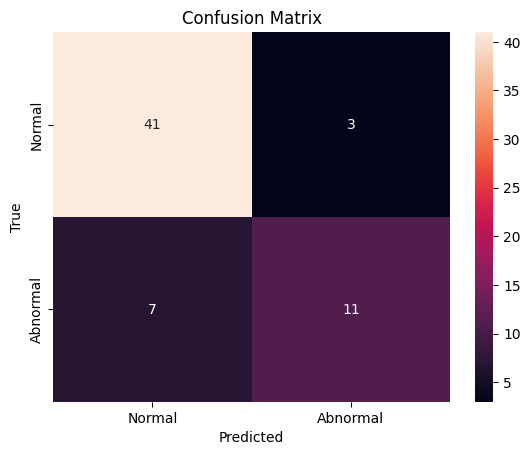

In [34]:
# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot = True, fmt='d', xticklabels = ['Normal', 'Abnormal'], yticklabels = ['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

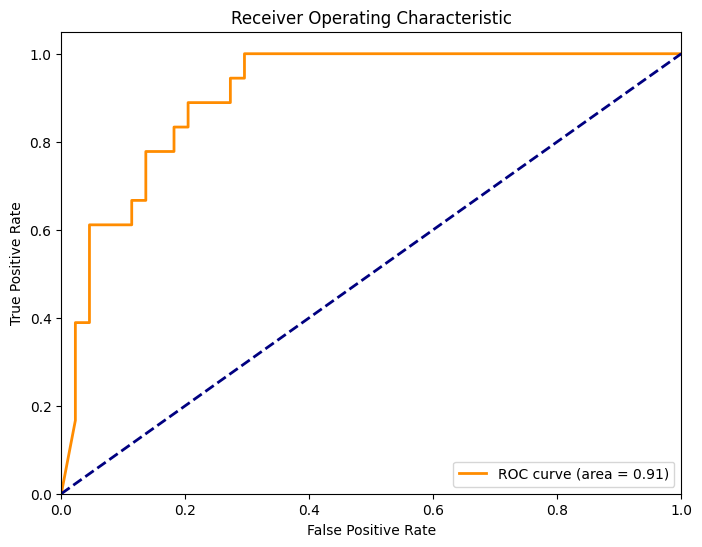

In [35]:
# Plot ROC curve and calculate AUC
fpr, tpr, _ = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

CROSS VALIDATION

Fold 1/5
(1) Training with params: weight_decay = 0.0001, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 117
(2) Training with params: weight_decay = 1e-05, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 81
(3) Training with params: weight_decay = 1e-06, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 103
(4) Training with params: weight_decay = 0.0001, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 88
(5) Training with params: weight_decay = 1e-05, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 34
(6) Training with params: weight_decay = 1e-06, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 105
(7) Training with params: weight_decay = 0.0001, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 52
(8) Training with params: weight_decay = 1e-05, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 87
(9) Training with params: weight_decay = 1e-06, learnin

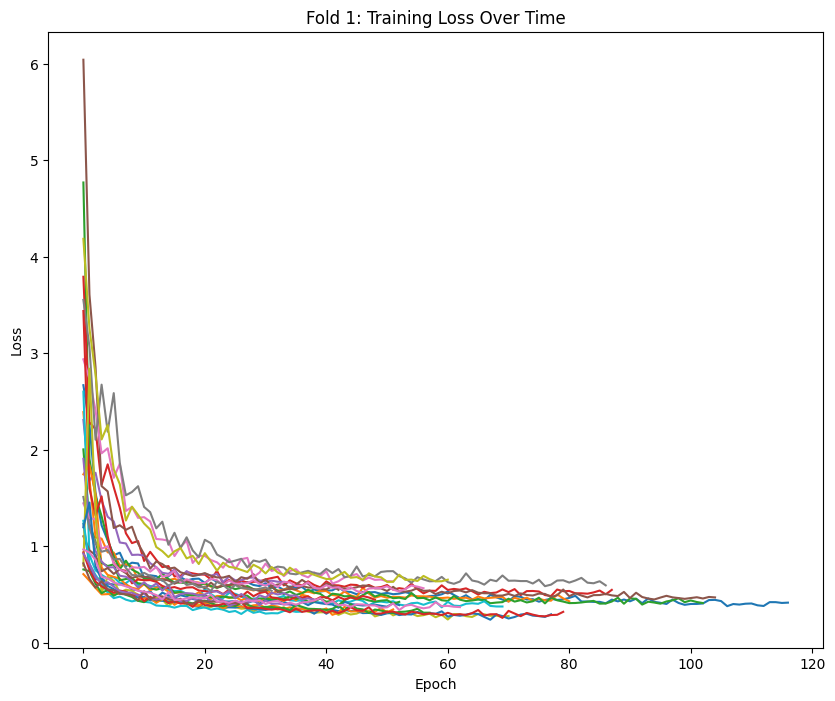

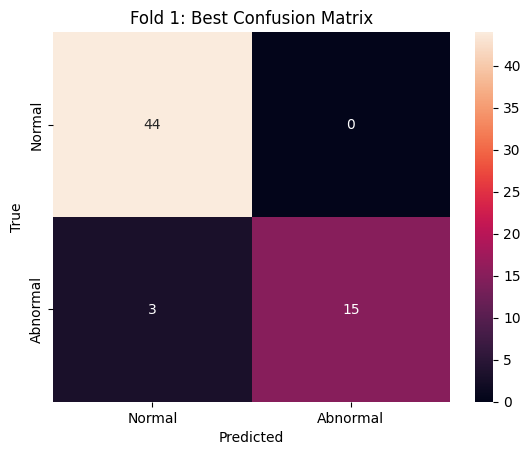

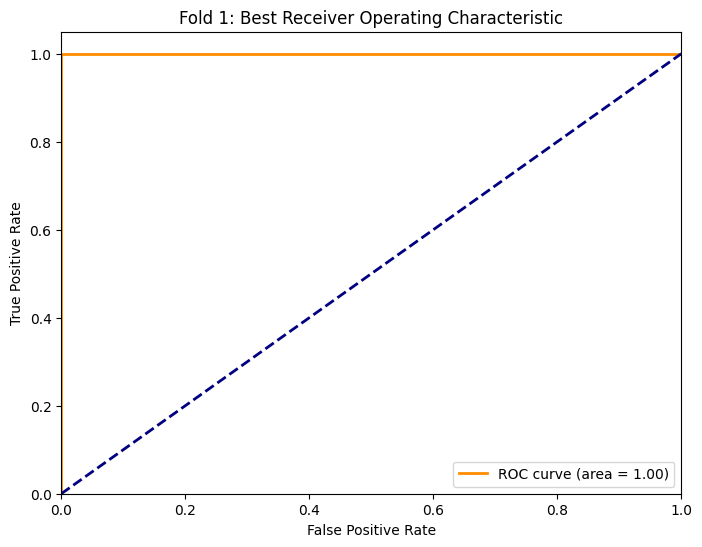

Fold 2/5
(1) Training with params: weight_decay = 0.0001, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 89
(2) Training with params: weight_decay = 1e-05, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 113
(3) Training with params: weight_decay = 1e-06, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 55
(4) Training with params: weight_decay = 0.0001, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 41
(5) Training with params: weight_decay = 1e-05, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 84
(6) Training with params: weight_decay = 1e-06, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 52
(7) Training with params: weight_decay = 0.0001, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 53
(8) Training with params: weight_decay = 1e-05, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 55
(9) Training with params: weight_decay = 1e-06, learning_

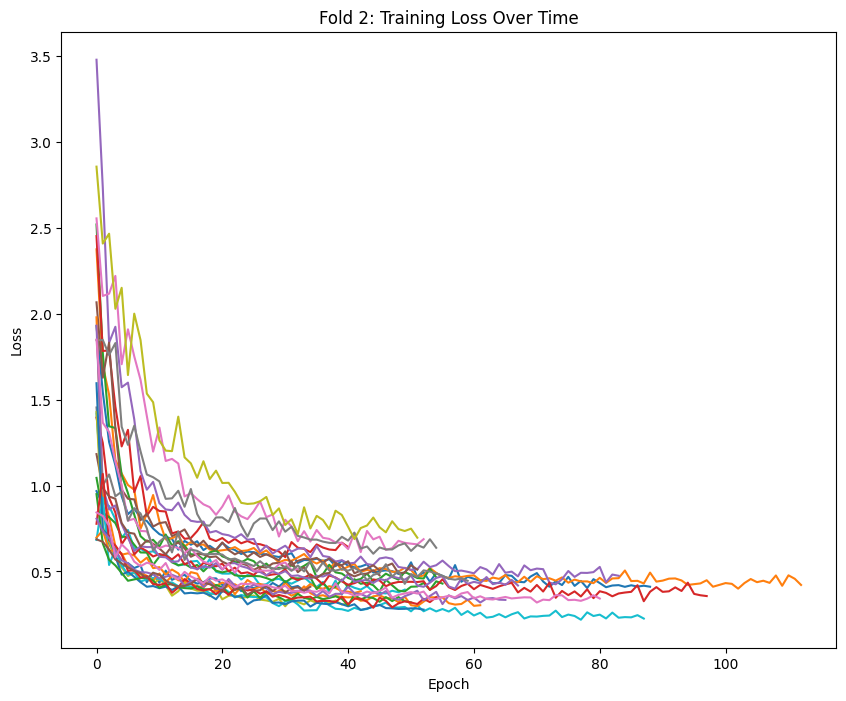

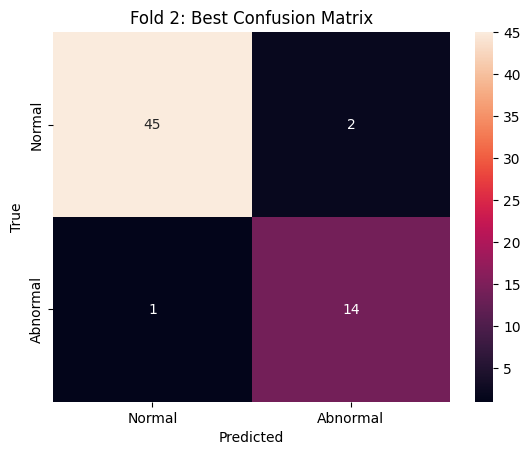

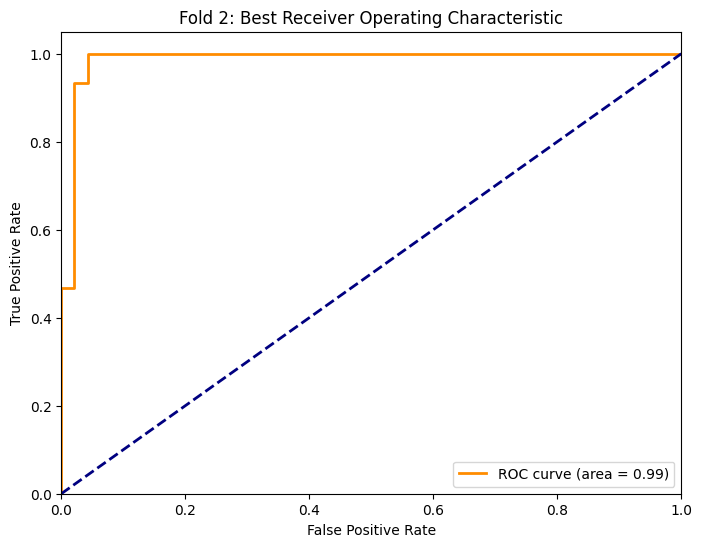

Fold 3/5
(1) Training with params: weight_decay = 0.0001, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 76
(2) Training with params: weight_decay = 1e-05, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 42
(3) Training with params: weight_decay = 1e-06, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 59
(4) Training with params: weight_decay = 0.0001, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 65
(5) Training with params: weight_decay = 1e-05, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 29
(6) Training with params: weight_decay = 1e-06, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 49
(7) Training with params: weight_decay = 0.0001, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 68
(8) Training with params: weight_decay = 1e-05, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 50
(9) Training with params: weight_decay = 1e-06, learning_r

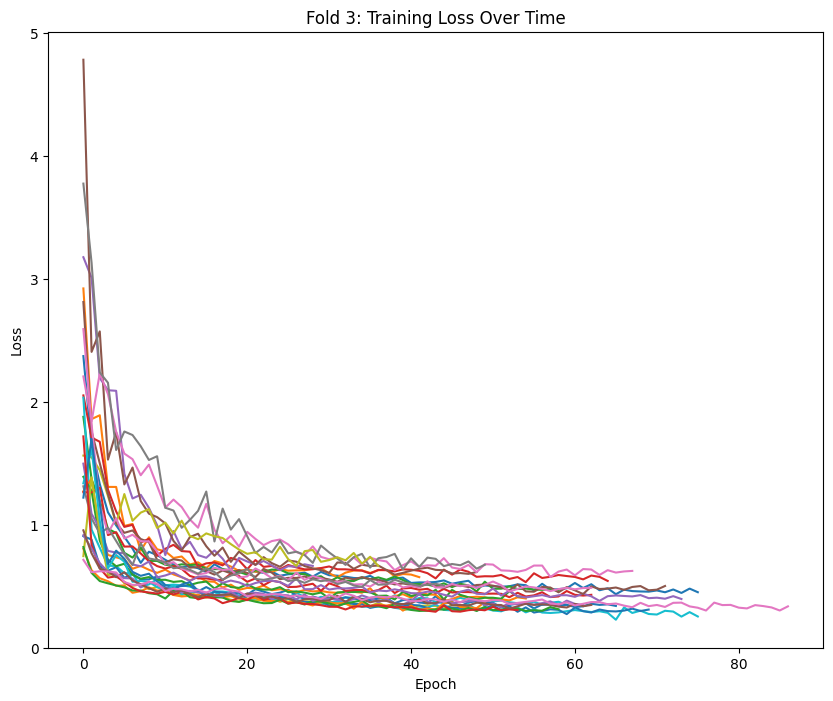

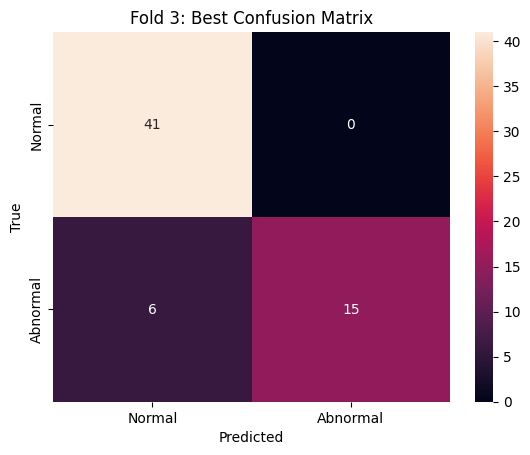

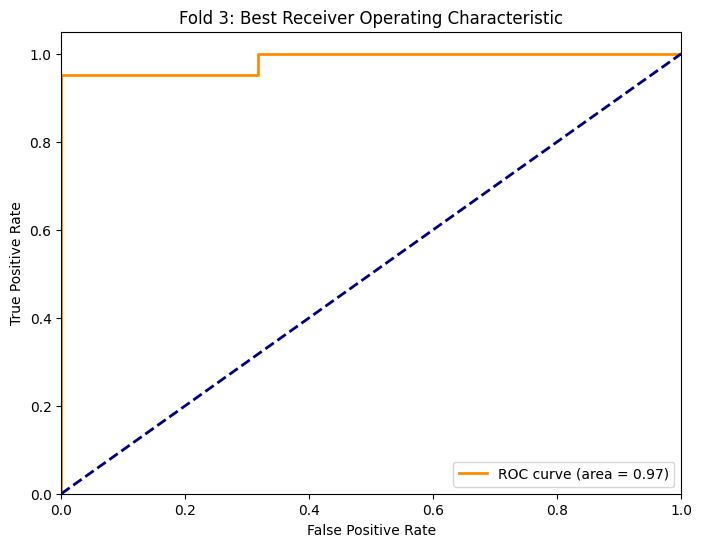

Fold 4/5
(1) Training with params: weight_decay = 0.0001, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 50
(2) Training with params: weight_decay = 1e-05, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 42
(3) Training with params: weight_decay = 1e-06, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 61
(4) Training with params: weight_decay = 0.0001, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 87
(5) Training with params: weight_decay = 1e-05, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 163
(6) Training with params: weight_decay = 1e-06, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 39
(7) Training with params: weight_decay = 0.0001, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 47
(8) Training with params: weight_decay = 1e-05, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 54
(9) Training with params: weight_decay = 1e-06, learning_

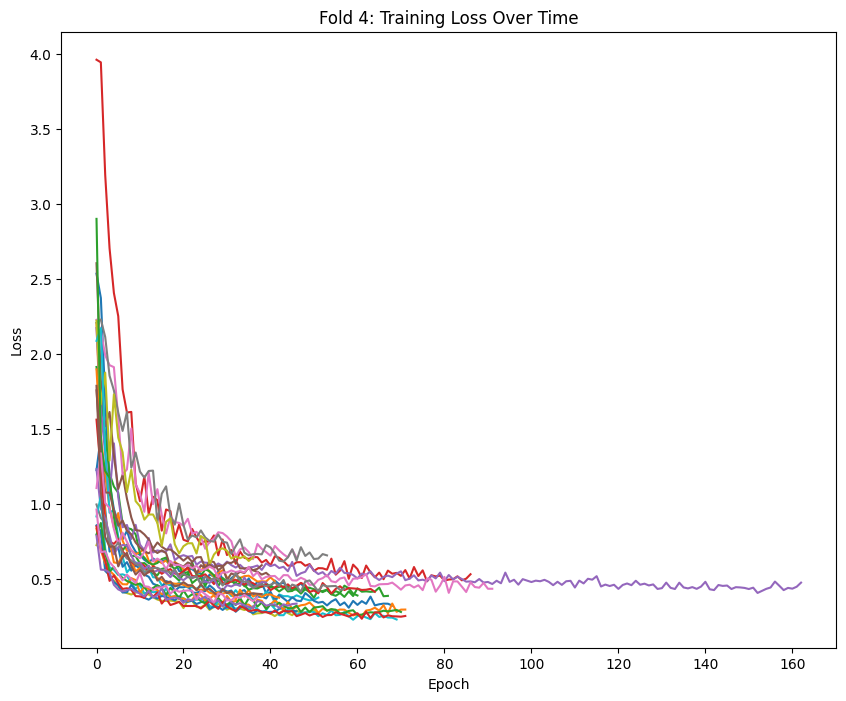

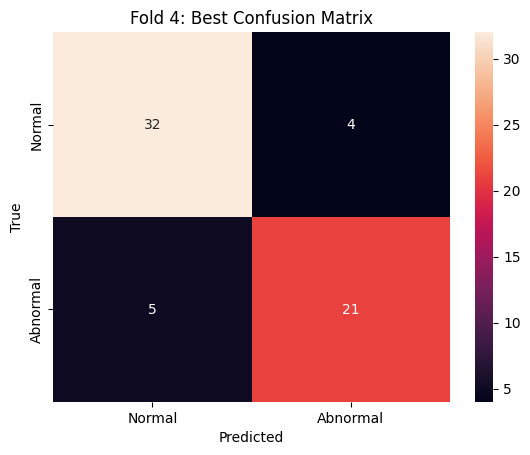

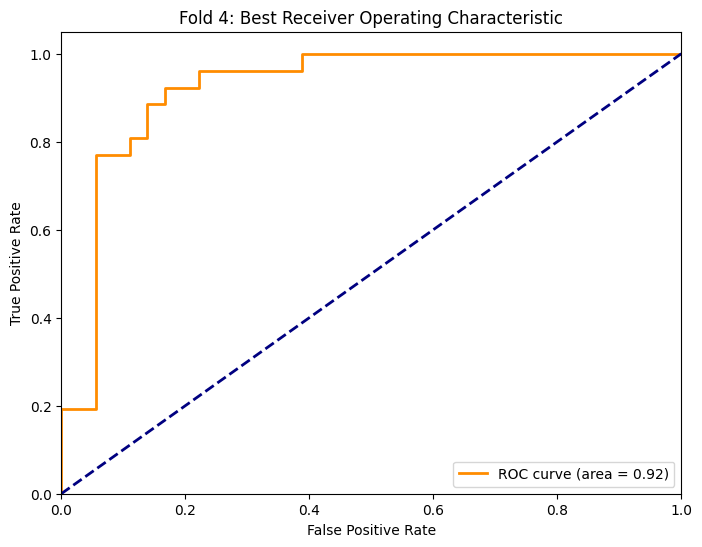

Fold 5/5
(1) Training with params: weight_decay = 0.0001, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 83
(2) Training with params: weight_decay = 1e-05, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 98
(3) Training with params: weight_decay = 1e-06, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 68
(4) Training with params: weight_decay = 0.0001, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 76
(5) Training with params: weight_decay = 1e-05, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 56
(6) Training with params: weight_decay = 1e-06, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 51
(7) Training with params: weight_decay = 0.0001, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 52
(8) Training with params: weight_decay = 1e-05, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 40
(9) Training with params: weight_decay = 1e-06, learning_r

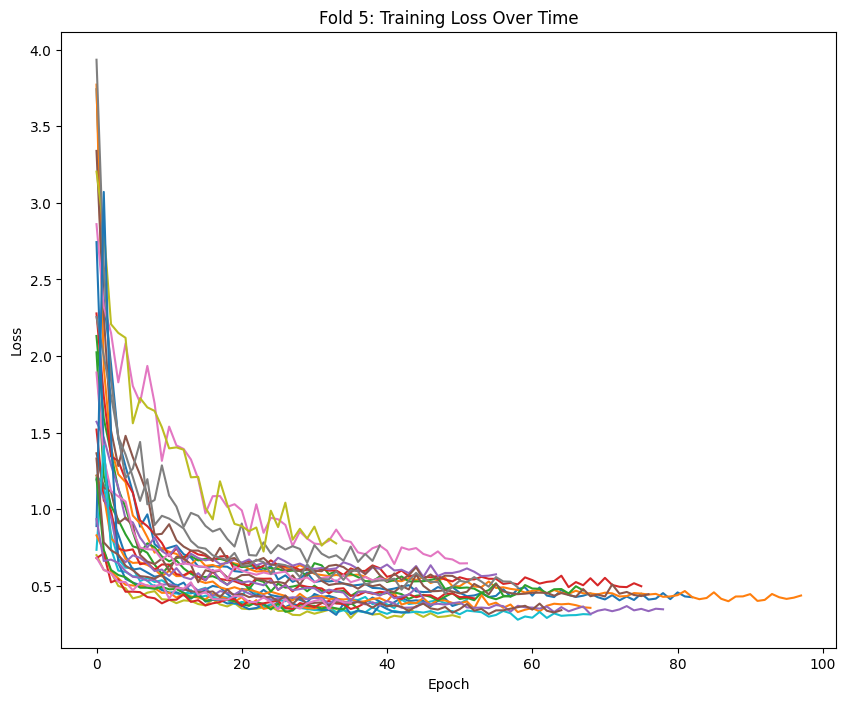

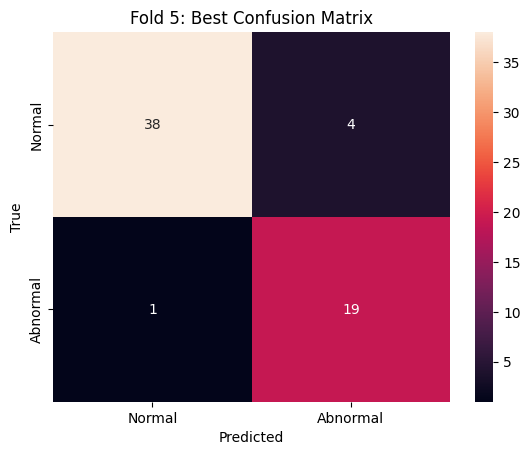

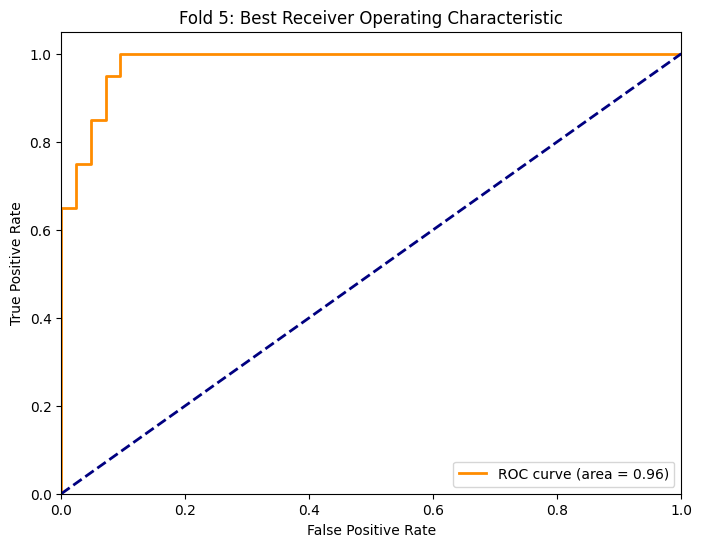

In [36]:
# Define the number of folds for cross-validation
k_folds = 5
kf = KFold(n_splits = k_folds, shuffle = True, random_state = 42)

# Initialize metrics to collect results from each fold
accuracies = []
precisions = []
recalls = []
f1s = []
roc_aucs = []

param_grid = {
    'learning_rate': [0.002, 0.001, 0.0005],
    'weight_decay': [1e-4, 1e-5, 1e-6],
    'dropout': [0.5, 0.3, 0.1]
}

# Perform K-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(node_features)):
    print(f'Fold {fold + 1}/{k_folds}')

    # Create lists to hold the results for plotting
    Count = 1
    loss_values_folds = []
    confusion_matrices = []
    roc_curves = []
    
    # Split data
    X_train, X_test = node_features[train_index], node_features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # Create Data objects for training and testing sets
    train_data = create_graph_data(X_train, y_train)
    test_data = create_graph_data(X_test, y_test)
    
    # Create DataLoader instances
    train_loader = GeometricDataLoader([train_data], batch_size = 1, shuffle = True)
    test_loader = GeometricDataLoader([test_data], batch_size = 1, shuffle = False)

    best_params = None
    best_fold_metrics = None
    best_fold_loss = float('inf')


    # Iterate over parameter combinations
    for params in ParameterGrid(param_grid):
        learning_rate = params['learning_rate']
        weight_decay = params['weight_decay']
        dropout = params['dropout']

        # Print the parameters being used
        print(f'({Count}) Training with params: weight_decay = {weight_decay}, learning_rate = {learning_rate}, dropout = {dropout}')
    
        # Initialize the model with the current set of parameters
        model = AdvancedGNNModel(num_node_features = 12, num_classes = 2, dropout = dropout)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
        criterion = torch.nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.9)
    
        # Train the model with early stopping
        epochs = 200
        early_stopping_patience = 10
        best_loss = float('inf')
        patience_counter = 0
        loss_values = []
        
        for epoch in range(epochs):
            model.train()
            epoch_loss = 0
            for batch in train_loader:
                optimizer.zero_grad()
                out = model(batch)
                loss = criterion(out, batch.y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 2.0)
                optimizer.step()
                epoch_loss += loss.item()
            scheduler.step()
            loss_values.append(epoch_loss / len(train_loader))
            
            # Early stopping
            epoch_loss /= len(train_loader)
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"    Early stopping at epoch {epoch+1}")
                    Count = Count + 1
                    break

        # Save the loss values for this fold
        loss_values_folds.append(loss_values)
        
        # Evaluate the model
        model.eval()
        true_labels = []
        predictions = []
        probs = []
        
        with torch.no_grad():
            for batch in test_loader:
                out = model(batch)
                _, pred = out.max(dim = 1)
                predictions.extend(pred.tolist())
                true_labels.extend(batch.y.tolist())
                probs.extend(F.softmax(out, dim = 1)[:, 1].tolist())
         
        # Convert lists to numpy arrays for metric calculation
        true_labels = np.array(true_labels)
        predictions = np.array(predictions)
        probs = np.array(probs)
        
        # Calculate metrics
        test_accuracy = accuracy_score(true_labels, predictions)
        test_precision = precision_score(true_labels, predictions, average = 'macro', zero_division = 0)
        test_recall = recall_score(true_labels, predictions, average = 'macro', zero_division = 0)
        test_f1 = f1_score(true_labels, predictions, average = 'macro', zero_division = 0)
        fpr, tpr, _ = roc_curve(true_labels, probs)
        test_roc_auc = auc(fpr, tpr)

        # Check if this parameter combination is the best for this fold
        if best_loss < best_fold_loss:
            best_fold_loss = best_loss
            best_params = params
            best_true_labels = true_labels
            best_predictions = predictions
            best_probs = probs
            best_fold_metrics = {
                'accuracy': test_accuracy,
                'precision': test_precision,
                'recall': test_recall,
                'f1': test_f1,
                'roc_auc': test_roc_auc
            }
    
    # Collect metrics for this fold
    accuracies.append(best_fold_metrics['accuracy'])
    precisions.append(best_fold_metrics['precision'])
    recalls.append(best_fold_metrics['recall'])
    f1s.append(best_fold_metrics['f1'])
    roc_aucs.append(best_fold_metrics['roc_auc'])

    print(f'Fold {fold + 1} - Best Params: {best_params}')
    print(f'Fold {fold + 1} - Accuracy: {best_fold_metrics["accuracy"]:.4f}, Precision: {best_fold_metrics["precision"]:.4f}, Recall: {best_fold_metrics["recall"]:.4f}, F1 Score: {best_fold_metrics["f1"]:.4f}, ROC AUC: {best_fold_metrics["roc_auc"]:.4f}')

    plt.figure(figsize = (10, 8))
    for loss_values in loss_values_folds:
        plt.plot(loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold + 1}: Training Loss Over Time')
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(best_true_labels, best_predictions)
    sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = ['Normal', 'Abnormal'], yticklabels = ['Normal', 'Abnormal'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Fold {fold + 1}: Best Confusion Matrix')
    plt.show()

    # Plot ROC curve and calculate AUC
    best_fpr, best_tpr, _ = roc_curve(best_true_labels, best_probs)
    best_roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(best_fpr, best_tpr, color = 'darkorange', lw = 2, label = f'ROC curve (area = {best_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Fold {fold + 1}: Best Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

In [37]:
print(f'\nCross-Validation Results:')
# Print overall metrics
print(f'Overall Metrics:')
print(f'Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}')
print(f'Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}')
print(f'Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}')
print(f'F1 Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}')
print(f'ROC AUC: {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}')


Cross-Validation Results:
Overall Metrics:
Accuracy: 0.9161 ± 0.0359
Precision: 0.9167 ± 0.0388
Recall: 0.8990 ± 0.0390
F1 Score: 0.9034 ± 0.0333
ROC AUC: 0.9752 ± 0.0268


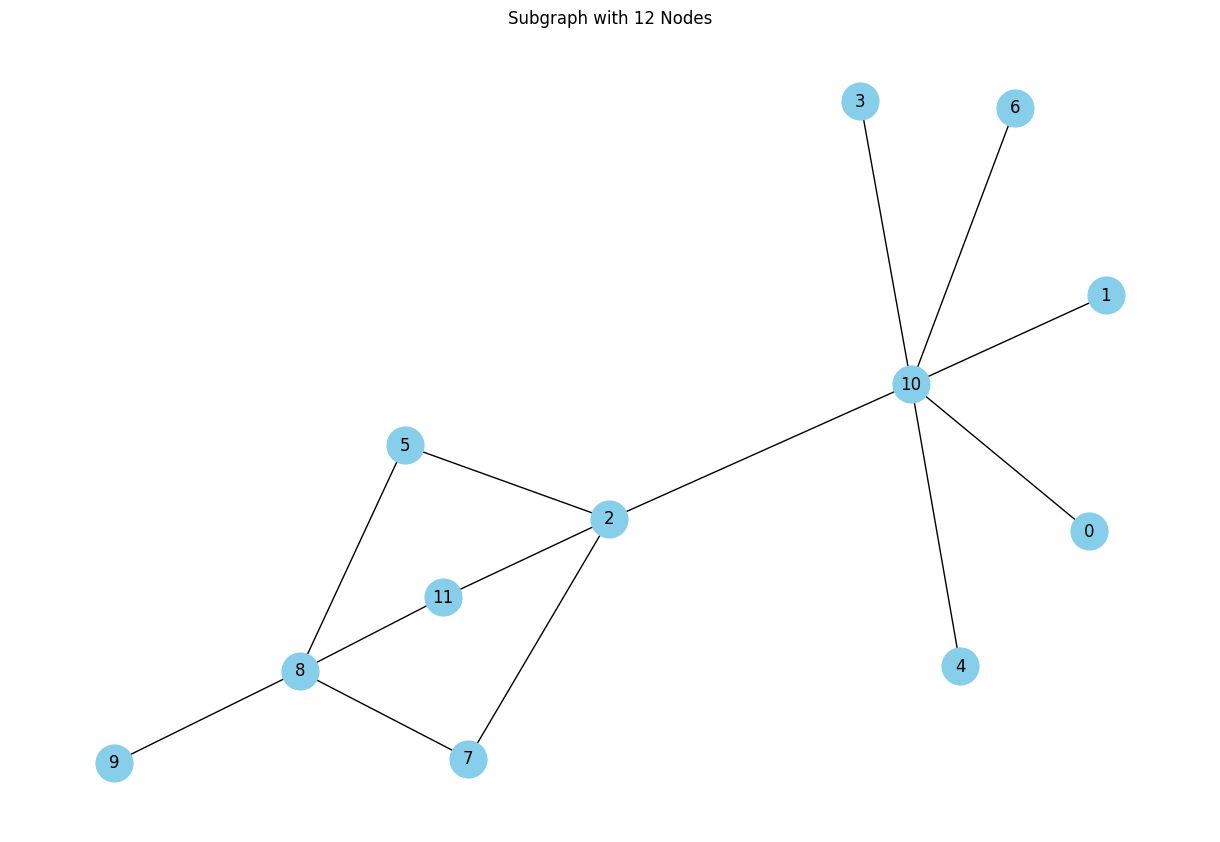

In [38]:
# Visualize subgraph
visualize_graph(create_custom_edge_index(), num_nodes = 12)

In [39]:
# Visualize the original and synthetic data
def plot_distribution(X_original, y_original, X_synthetic, y_synthetic):
    features = ["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", "sacral_slope", "pelvic_radius",
                "degree_spondylolisthesis", "pelvic_slope", "Direct_tilt", "thoracic_slope", "cervical_tilt",
                "sacrum_angle", "scoliosis_slope"]
    
    fig, axs = plt.subplots(len(features), 2, figsize=(15, 30))

    for i, feature in enumerate(features):
        sns.histplot(X_original[:, i], kde=True, color='blue', label='Original', ax=axs[i, 0])
        sns.histplot(X_synthetic[:, i], kde=True, color='red', label='Synthetic', ax=axs[i, 0])
        axs[i, 0].set_title(f'Histogram of {feature}')
        axs[i, 0].legend()
        
        sns.kdeplot(X_original[:, i], color='blue', label='Original', ax=axs[i, 1])
        sns.kdeplot(X_synthetic[:, i], color='red', label='Synthetic', ax=axs[i, 1])
        axs[i, 1].set_title(f'KDE of {feature}')
        axs[i, 1].legend()

    plt.tight_layout()
    plt.show()

# Generate synthetic data by averaging a given number of samples
def create_averaged_data(X, y, window_size):
    n_samples = X.shape[0] // window_size
    X_averaged = np.array([X[i*window_size:(i+1)*window_size].mean(axis=0) for i in range(n_samples)])
    y_averaged = np.array([np.bincount(y[i*window_size:(i+1)*window_size]).argmax() for i in range(n_samples)])
    return X_averaged, y_averaged

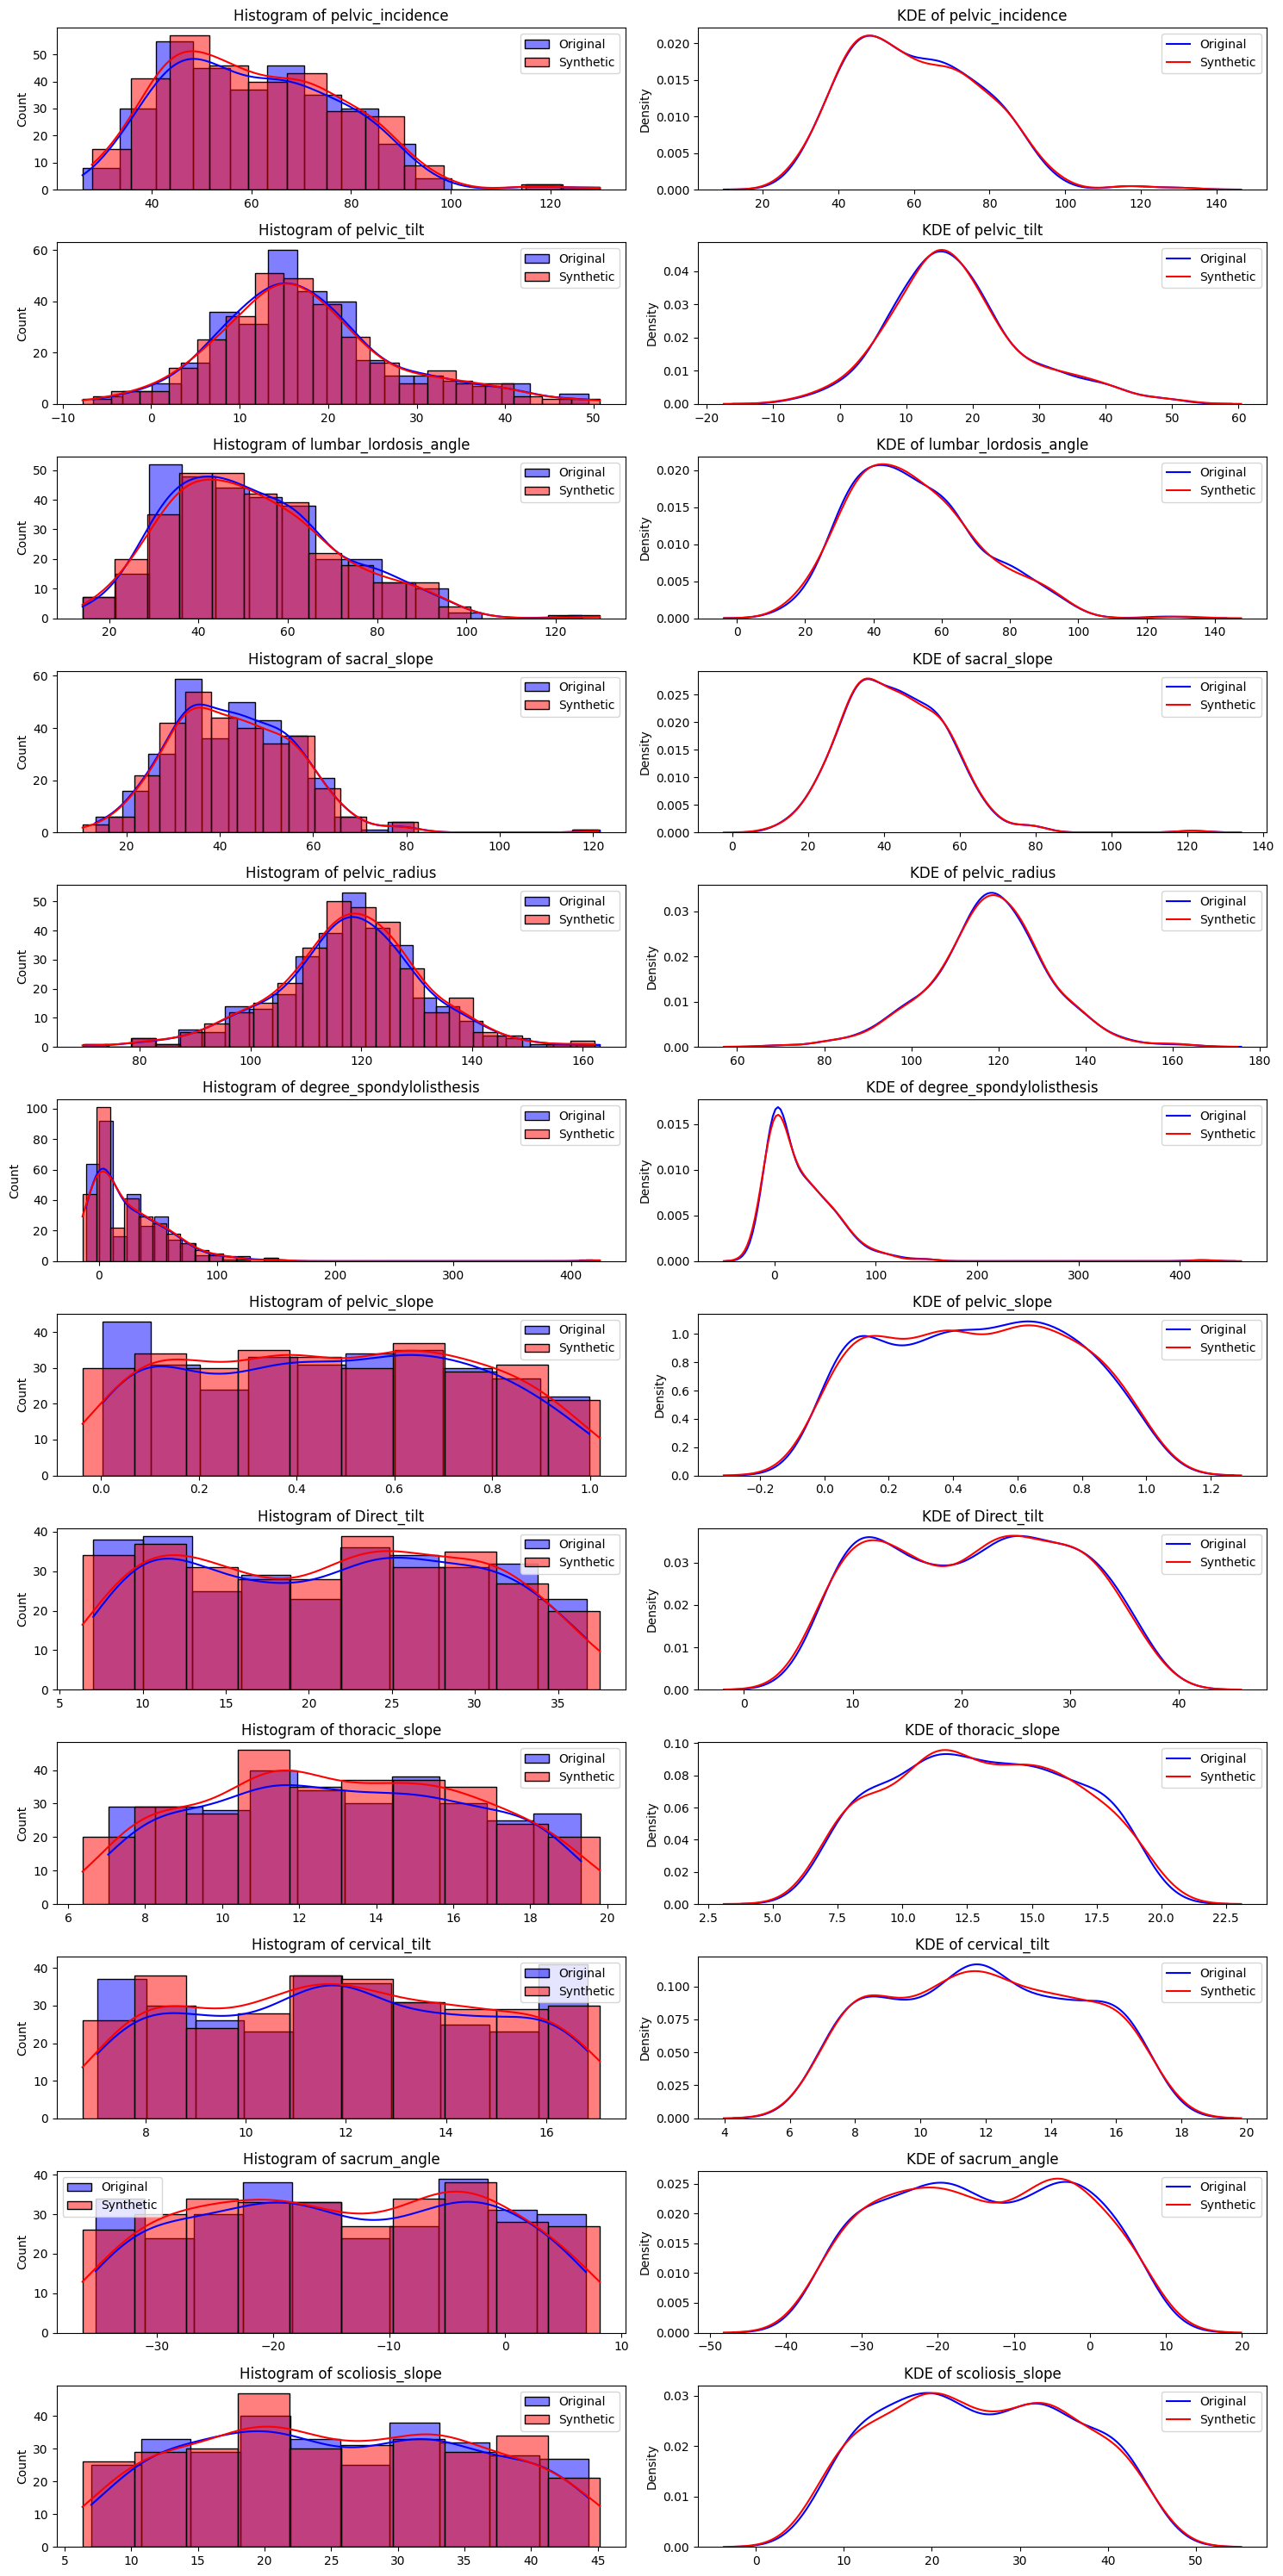

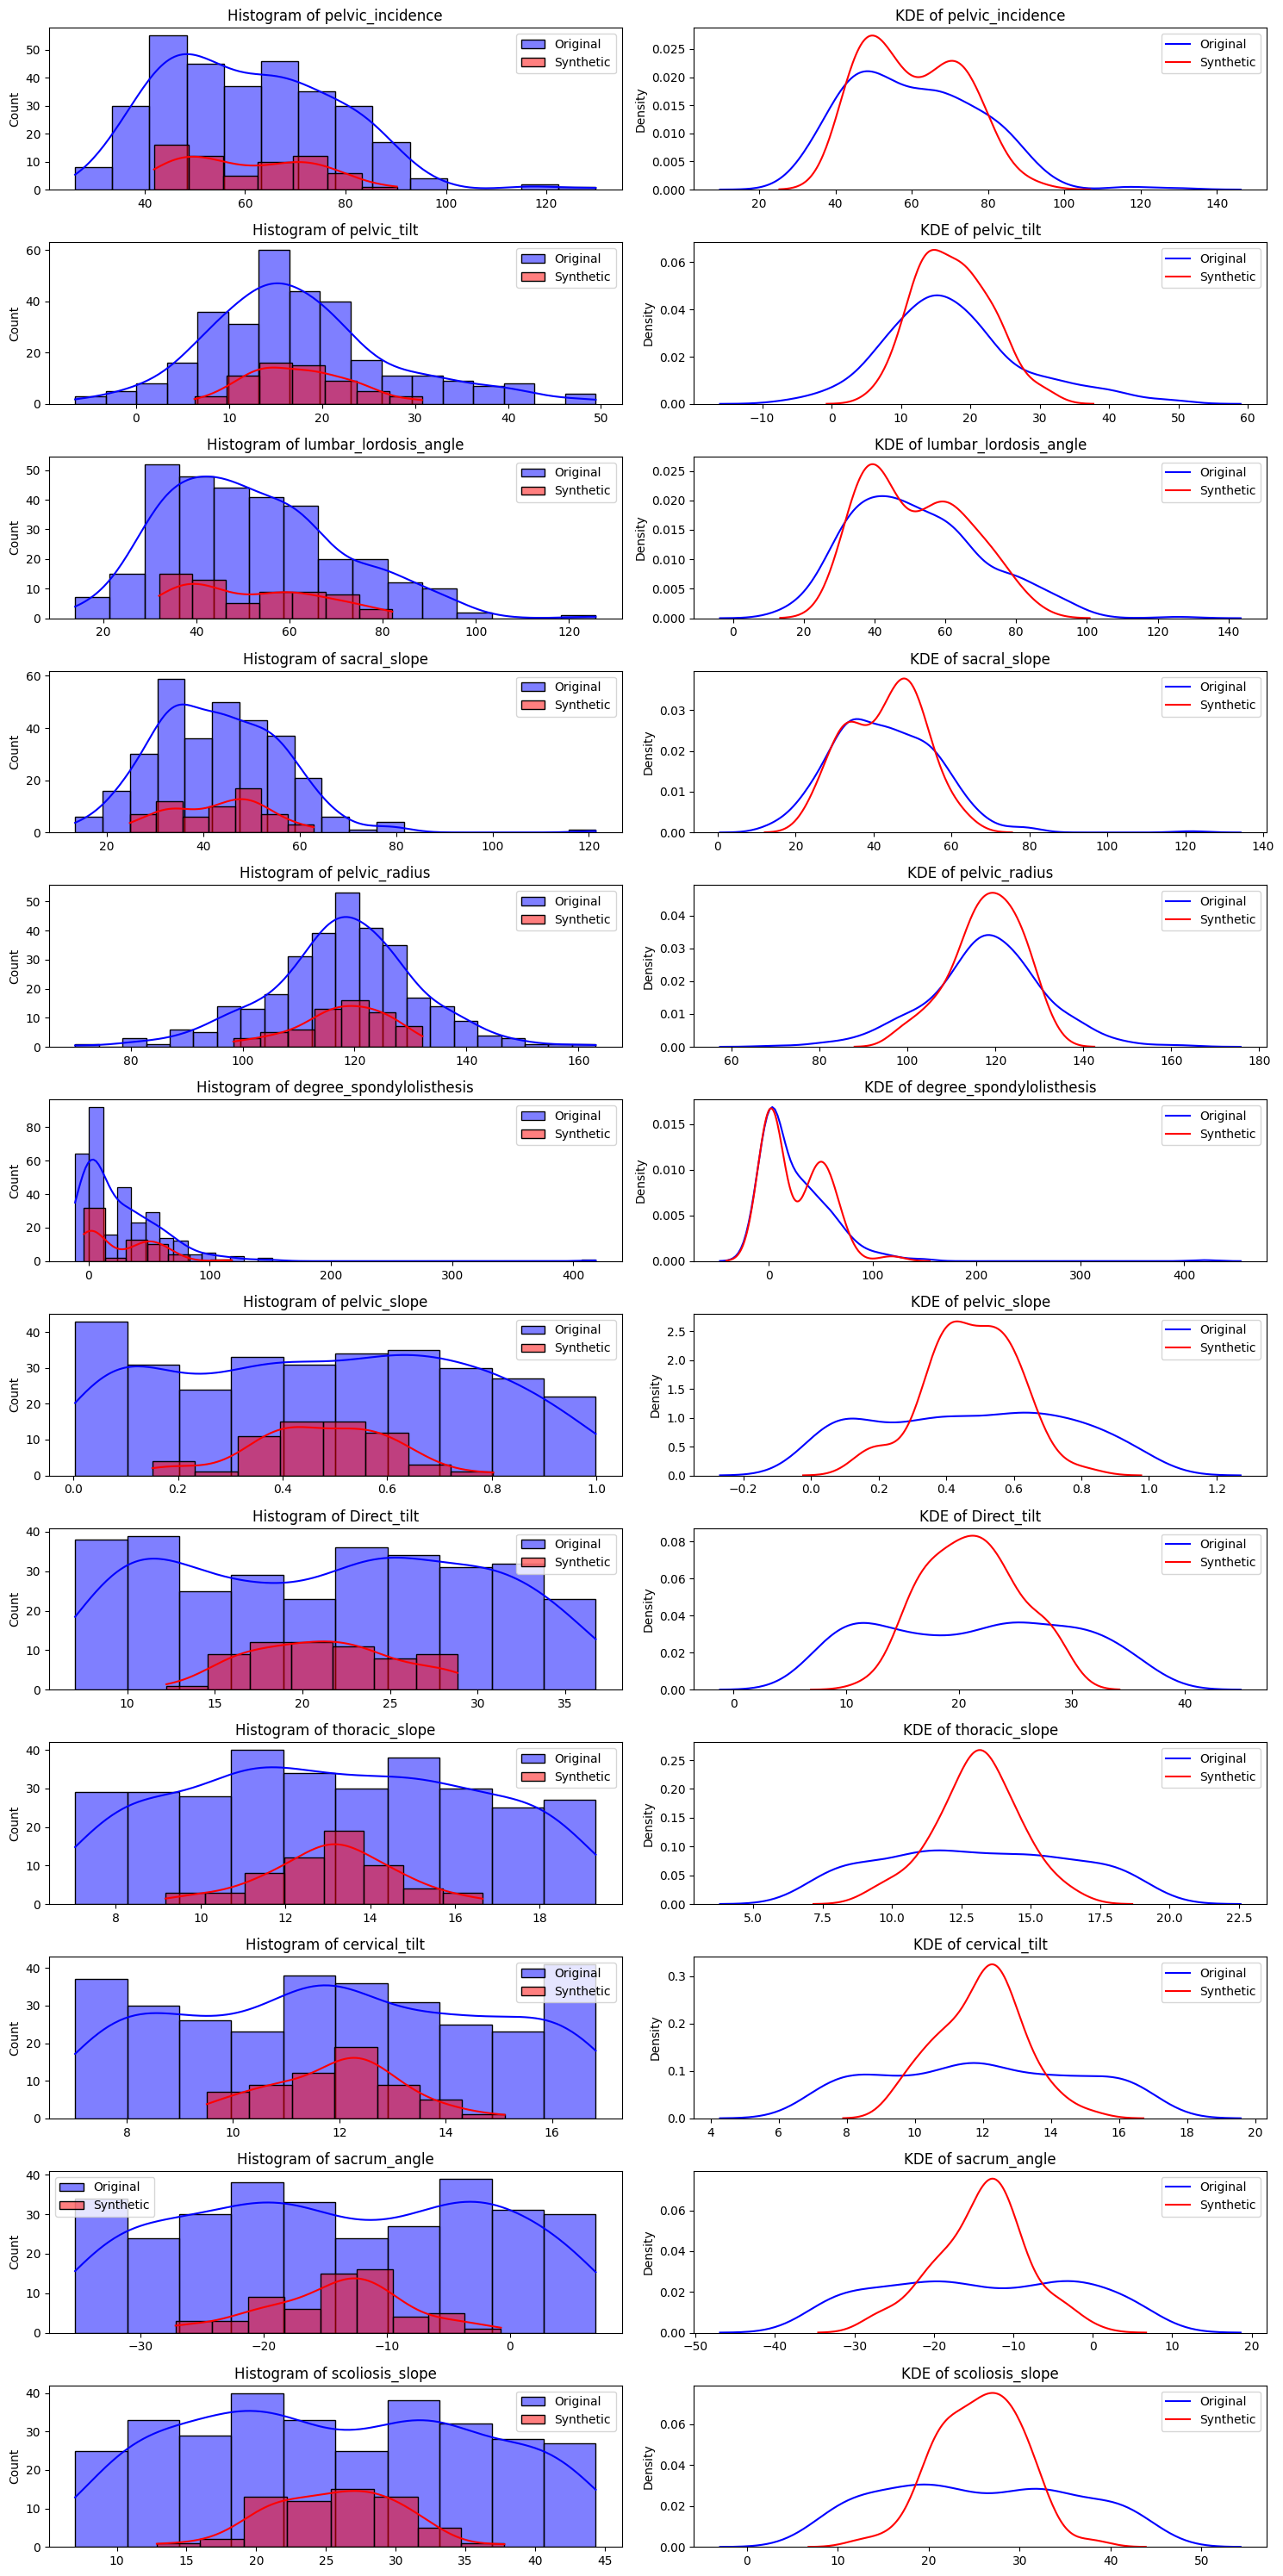

In [40]:
# Normalize the data
scaler = StandardScaler()
node_features_scaled = scaler.fit_transform(node_features)

# Generate synthetic data by adding Gaussian noise
noise_factor = 0.1
data_synthetic_scaled_noise = node_features_scaled + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=node_features_scaled.shape)
data_synthetic_noise = scaler.inverse_transform(data_synthetic_scaled_noise)

# Set the window size for averaging
window_size = 5
data_synthetic_scaled_average, labels_synthetic_average = create_averaged_data(data_synthetic_scaled_noise, labels, window_size)
data_synthetic_average = scaler.inverse_transform(data_synthetic_scaled_average)

plot_distribution(node_features, labels, data_synthetic_noise, labels)
plot_distribution(node_features, labels, data_synthetic_average, labels_synthetic_average)

Synthetic Data Accuracy: 0.9839
Synthetic Data Precision: 0.9762
Synthetic Data Recall: 0.9881
Synthetic Data F1 Score: 0.9818
Synthetic Data ROC AUC: 1.0000


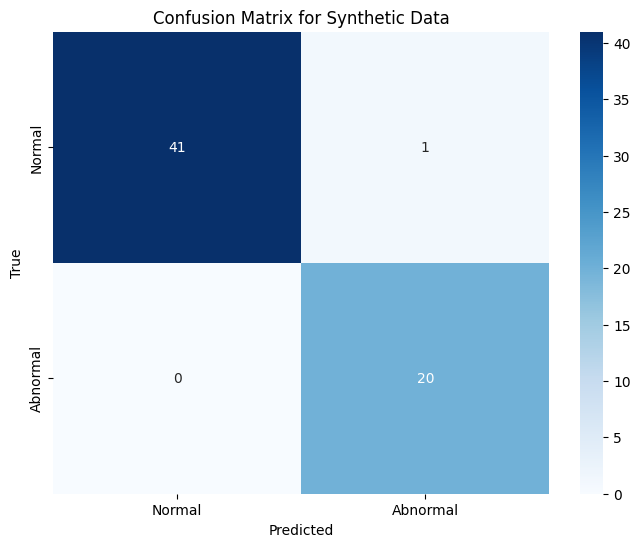

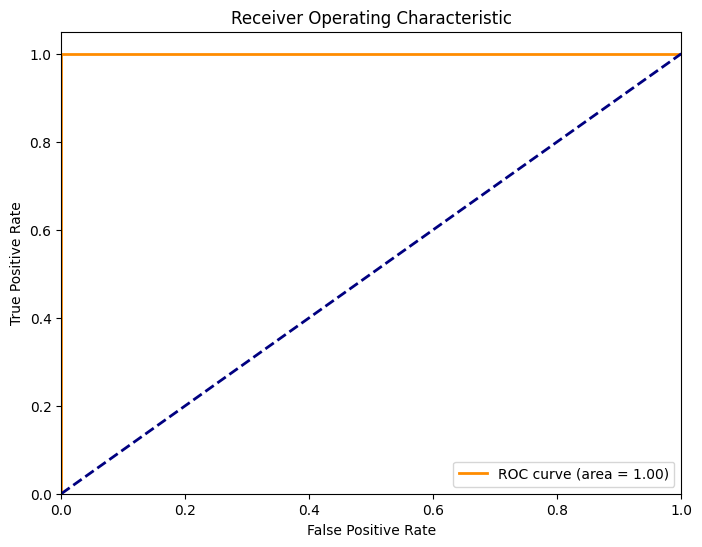

In [41]:
# Convert to PyTorch tensors
synthetic_data_tensor = torch.tensor(data_synthetic_average, dtype=torch.float)
synthetic_labels_tensor = torch.tensor(labels_synthetic_average, dtype=torch.long)

# Create Data object for combined data
synthetic_graph_data = create_graph_data(synthetic_data_tensor, synthetic_labels_tensor)

# Create DataLoader instance
synthetic_data_loader = GeometricDataLoader([synthetic_graph_data], batch_size=1, shuffle=False)

model.eval()

# Evaluate the model with combined data
synthetic_predictions = []
synthetic_probs = []

with torch.no_grad():
    for batch in synthetic_data_loader:
        output = model(batch)
        _, pred = output.max(dim=1)
        synthetic_predictions.extend(pred.tolist())
        synthetic_probs.extend(torch.softmax(output, dim=1)[:, 1].tolist())

# Convert lists to numpy arrays for metric calculation
synthetic_predictions = np.array(synthetic_predictions)
synthetic_probs = np.array(synthetic_probs)

# Calculate metrics
synthetic_accuracy = accuracy_score(labels_synthetic_average, synthetic_predictions)
synthetic_precision = precision_score(labels_synthetic_average, synthetic_predictions, average='macro', zero_division=0)
synthetic_recall = recall_score(labels_synthetic_average, synthetic_predictions, average='macro', zero_division=0)
synthetic_f1 = f1_score(labels_synthetic_average, synthetic_predictions, average='macro', zero_division=0)
fpr, tpr, _ = roc_curve(labels_synthetic_average, synthetic_probs)
synthetic_roc_auc = auc(fpr, tpr)

print(f'Synthetic Data Accuracy: {synthetic_accuracy:.4f}')
print(f'Synthetic Data Precision: {synthetic_precision:.4f}')
print(f'Synthetic Data Recall: {synthetic_recall:.4f}')
print(f'Synthetic Data F1 Score: {synthetic_f1:.4f}')
print(f'Synthetic Data ROC AUC: {synthetic_roc_auc:.4f}')

# Plot the confusion matrix
cm = confusion_matrix(labels_synthetic_average, synthetic_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Synthetic Data')
plt.show()

# Plot ROC curve and calculate AUC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {synthetic_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()